## Some function definitions

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import seaborn as sns

!jupyter nbextension enable --py widgetsnbextension

#all models we have - don't change
all_models = ['KNN','GNB','RF','Baseline']

#all days to train - can change based on the times you have trained
all_days=[30,60,90,120,180]

#corresponding names and colors - don't change
model_names={'KNN':'K-Nearest Neighbor','GNB':'Gaussian Naive Bayes','DT': 'Decision Tree','RF': 'Random Forest','Baseline': 'Baseline'}
m_colors={'Baseline':'#003f5c','RF':'#7a5195','GNB':'#ef5675','KNN':'#ffa600','DT':'#F4D4D4'}
t_colors = {30:'#488f31',60:'#bab874',90:'#feebd4',120:'#eb9d7b',180:'#de425b'}

Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:

def plot_feature_importance(importances,model_type):

	#Create arrays from feature importance and feature names
	feature_importance = np.array(importances['importance'])
	feature_names = np.array(importances.index)

	#Create a DataFrame using a Dictionary
	data={'feature_names':feature_names,'feature_importance':feature_importance}
	fi_df = pd.DataFrame(data)

	#Sort the DataFrame in order decreasing feature importance
	fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

	#Define size of bar plot
	plt.figure(figsize=(10,8))
	#Plot Searborn bar chart
	sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
	#Add chart labels
	plt.title(model_type + ' Feature Importances')
	plt.xlabel('FEATURE IMPORTANCE')
	plt.ylabel('FEATURE NAMES')

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
def prediction_meanings(matrices,name):
    if name == 'Death':
        labels = ['Death','No Death']
    elif name == 'Hospitalizations':
        labels = ['Hospitalization','No Hospitalization']
    elif name =='Risk':
        labels = ['High Risk','Low Risk']

    #average prediction results over all folds
    matrix = np.mean(matrices,axis=0)
    
    #convert to percentages
    m= matrix*100/matrix.sum()
    
    #plot the matrix
    fig, ax = plt.subplots(1,1,figsize=(6,4))
#     plt.figure(figsize=(3,2))
    disp=ConfusionMatrixDisplay(np.flip(np.transpose(m)),display_labels=labels)
    disp.plot(values_format='.1f',ax=ax)
    ax.set_xlabel("True Label")
    ax.set_ylabel("Predicted Label")
    plt.show()

In [4]:
def regression_roc_auc_score(y_true, y_pred, num_rounds = 'exact'):
#   """
#   Computes Regression-ROC-AUC-score.
  
#   Parameters:
#   ----------
#   y_true: array-like of shape (n_samples,). Binary or continuous target variable.
#   y_pred: array-like of shape (n_samples,). Target scores.
#   num_rounds: int or string. If integer, number of random pairs of observations. 
#               If string, 'exact', all possible pairs of observations will be evaluated.
  
#   Returns:
#   -------
#   rroc: float. Regression-ROC-AUC-score.
#   """
  
#   import numpy as np
    
#   y_true = np.array(y_true)
#   y_pred = np.array(y_pred)

    num_pairs = 0
    num_same_sign = 0
#     print(y_true)
  
#     print('yield pairs')
#     for x in _yield_pairs(y_true, num_rounds):
#         print (x)
    for i, j in _yield_pairs(y_true, num_rounds):
#         print('i',i)
#         print('j',j)
#         print('y_true i',y_true[i])
#         print('y_true j',y_true[j])

        diff_true = y_true[i] - y_true[j]
        diff_score = y_pred[i] - y_pred[j]
        if diff_true * diff_score > 0:
          num_same_sign += 1
        elif diff_score == 0:
          num_same_sign += .5
        num_pairs += 1

    return num_same_sign / num_pairs


def _yield_pairs(y_true, num_rounds):
    """
    Returns pairs of valid indices. Indices must belong to observations having different values.

    Parameters:
    ----------
    y_true: array-like of shape (n_samples,). Binary or continuous target variable.
    num_rounds: int or string. If integer, number of random pairs of observations to return. 
              If string, 'exact', all possible pairs of observations will be returned.

    Yields:
    -------
    i, j: tuple of int of shape (2,). Indices referred to a pair of samples.

    """
#   import numpy as np
    if num_rounds == 'exact':
        for i in range(len(y_true)):
            for j in np.where((y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
                yield i, j     
    else:
        for r in range(num_rounds):
            i = np.random.choice(range(len(y_true)))
            j = np.random.choice(np.where(y_true != y_true[i])[0])
            yield i, j



from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
def output_metrics(outs):
#     average_matrix=np.mean(matrices,axis=0)
    r2s = []
    maes=[]
    rmses=[]
    aucs=[]
    for out in outs[:-1]:
        r2 = r2_score(out[0],out[1])
        r2s.append(r2)
        mae = mean_absolute_error(out[0],out[1])
        maes.append(mae)
        mse = mean_squared_error(out[0],out[1])
        rmses.append(np.sqrt(mse))
        auc = regression_roc_auc_score(out[0],out[1])
        aucs.append(auc)
    r2=np.mean(r2s)
    mae=np.mean(maes)
    rmse=np.mean(rmses)
    auc=np.mean(aucs)
    print("r2 :",r2)
    print('mae:',mae)
    print('rmse:',rmse)
    print('auc:',auc)
    print('Feature Importance',outs[-1].head(10))
    return([outs,r2s,maes,rmses,aucs])

In [5]:
t_dropdown = widgets.Dropdown(options=all_days, value = all_days[0],description='Time to discharge: ', disabled = False)
def comparisons(name):
    display(t_dropdown)
    #Choose the time you want
    t=t_dropdown.value

    d_name=str(t)+' days from discharge'

    plt.rcParams["figure.figsize"] = (30,14)
    fig, ax = plt.subplots()

    #labels for the graph
    if name == 'Death':
        labels = ['Acc_Overall','Acc_No_Death','Acc_Death']
        tg=time_graphs1
    elif name == 'Hospitalizations':
        labels = ['Acc_Overall','Acc_No_Hospitalization','Acc_Hospitalization']
        tg = time_graphsh
    elif name =='Risk':
        labels = ['Acc_Overall','Acc_Low_Risk','Acc_High_Risk']
        tg=time_graphs3
        
    x = np.arange(len(labels)) #the label locations
    width = 0.16  #the width of the bars

    #plot the bars
    rects = []
    for i in range(len(models)):
        model = models[i]
        pos = i - len(models)/2
        rects.append(ax.bar(x + pos*width, tg[t][model][-3:], width, label=model_names[model],color=m_colors[model]))

    # to provide numbered labels on top of figure
    for rect in rects:
        for r in rect:
            height = r.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(r.get_x() + r.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=21)



    # Add some text for labels, title and custom x-axis tick labels, etc. and plot the graph
    ax.set_ylabel('Percentage Accuracies',fontsize=44)
    ax.set_title('Predicting '+name+': '+d_name,fontsize=44)
    ax.set_xticks(x)
    ax.set_xticklabels(labels,fontsize=36)
    ax.legend(fontsize=20,loc='upper left')
    plt.yticks(fontsize=34)
    plt.xticks(fontsize=34)
    ax.set_ylim([0,140])
    plt.grid(which='both',axis='y',color='gray', linestyle='--', linewidth=.5)
    plt.minorticks_on()
    return(fig,ax)

In [6]:
m_dropdown = widgets.Dropdown(options=all_models, value = all_models[0],description='Model: ', disabled = False)
def time_comparisons(name):
    display(m_dropdown)
    #Choose the time you want
    m=m_dropdown.value

    d_name=str(m)

    plt.rcParams["figure.figsize"] = (30,14)
    fig, ax = plt.subplots()

    #labels for the graph
    if name == 'Death':
        labels = ['Acc_Overall','Acc_No_Death','Acc_Death']
        tg=time_graphs1
    elif name == 'Hospitalizations':
        labels = ['Acc_Overall','Acc_No_Hospitalization','Acc_Hospitalization']
        tg = time_graphsh
    elif name =='Risk':
        labels = ['Acc_Overall','Acc_Low_Risk','Acc_High_Risk']
        tg=time_graphs3
        
    x = np.arange(len(labels)) #the label locations
    width = 0.16  #the width of the bars

    #plot the bars
    rects = []
    for i in range(len(days)):
        t = days[i]
        pos = i - len(days)/2
        rects.append(ax.bar(x + pos*width, tg[t][m][-3:], width, label=days[i],color=t_colors[t]))

    # to provide numbered labels on top of figure
    for rect in rects:
        for r in rect:
            height = r.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(r.get_x() + r.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=21)



    # Add some text for labels, title and custom x-axis tick labels, etc. and plot the graph
    ax.set_ylabel('Percentage Accuracies',fontsize=44)
    ax.set_title('Predicting '+name+' within N days: '+d_name,fontsize=44)
    ax.set_xticks(x)
    ax.set_xticklabels(labels,fontsize=36)
    ax.legend(fontsize=20,loc='upper left')
    plt.yticks(fontsize=34)
    plt.xticks(fontsize=34)
    ax.set_ylim([0,140])
    plt.grid(which='both',axis='y',color='gray', linestyle='--', linewidth=.5)
    plt.minorticks_on()
    return(fig,ax)

# Visualizations for Predictive Models for Death

## Predictive Models for Death - Load Models

In [7]:
#Select the models and days you want to load for visualizations - make sure the relevant files are there.
models = ['Baseline','GNB','KNN','RF']
days = all_days

#loads them up into this dictionary
time_graphs1={}
for d in days:
    time_graphs1[d]={}

for d in days:
    for model in models:
        with open('../results/'+model+'_'+str(d)+'_death_final_new.pkl', 'rb') as file:
            time_graphs1[d][model] = pickle.load(file)



## Predictive Models for Death - Plot comparisons between models and comparisons over time

Dropdown(description='Time to discharge: ', options=(30, 60, 90, 120, 180), value=30)

(<Figure size 2160x1008 with 1 Axes>,
 <AxesSubplot:title={'center':'Predicting Death: 30 days from discharge'}, ylabel='Percentage Accuracies'>)

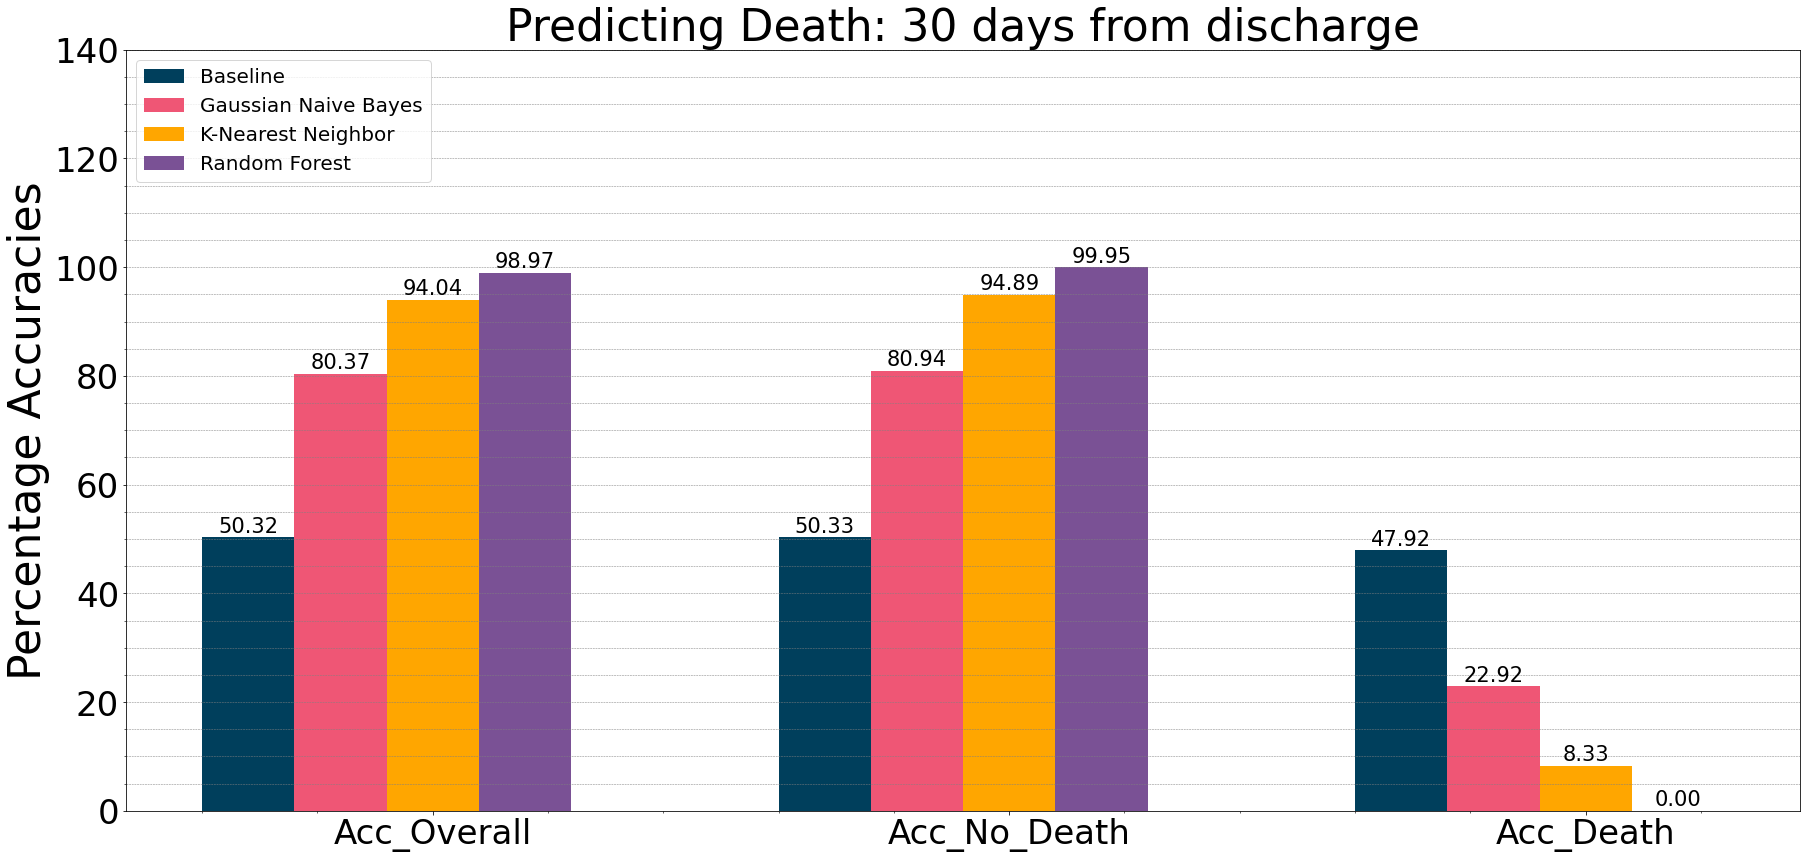

In [8]:
comparisons('Death')

Dropdown(description='Model: ', options=('KNN', 'GNB', 'RF', 'Baseline'), value='KNN')

(<Figure size 2160x1008 with 1 Axes>,
 <AxesSubplot:title={'center':'Predicting Death within N days: KNN'}, ylabel='Percentage Accuracies'>)

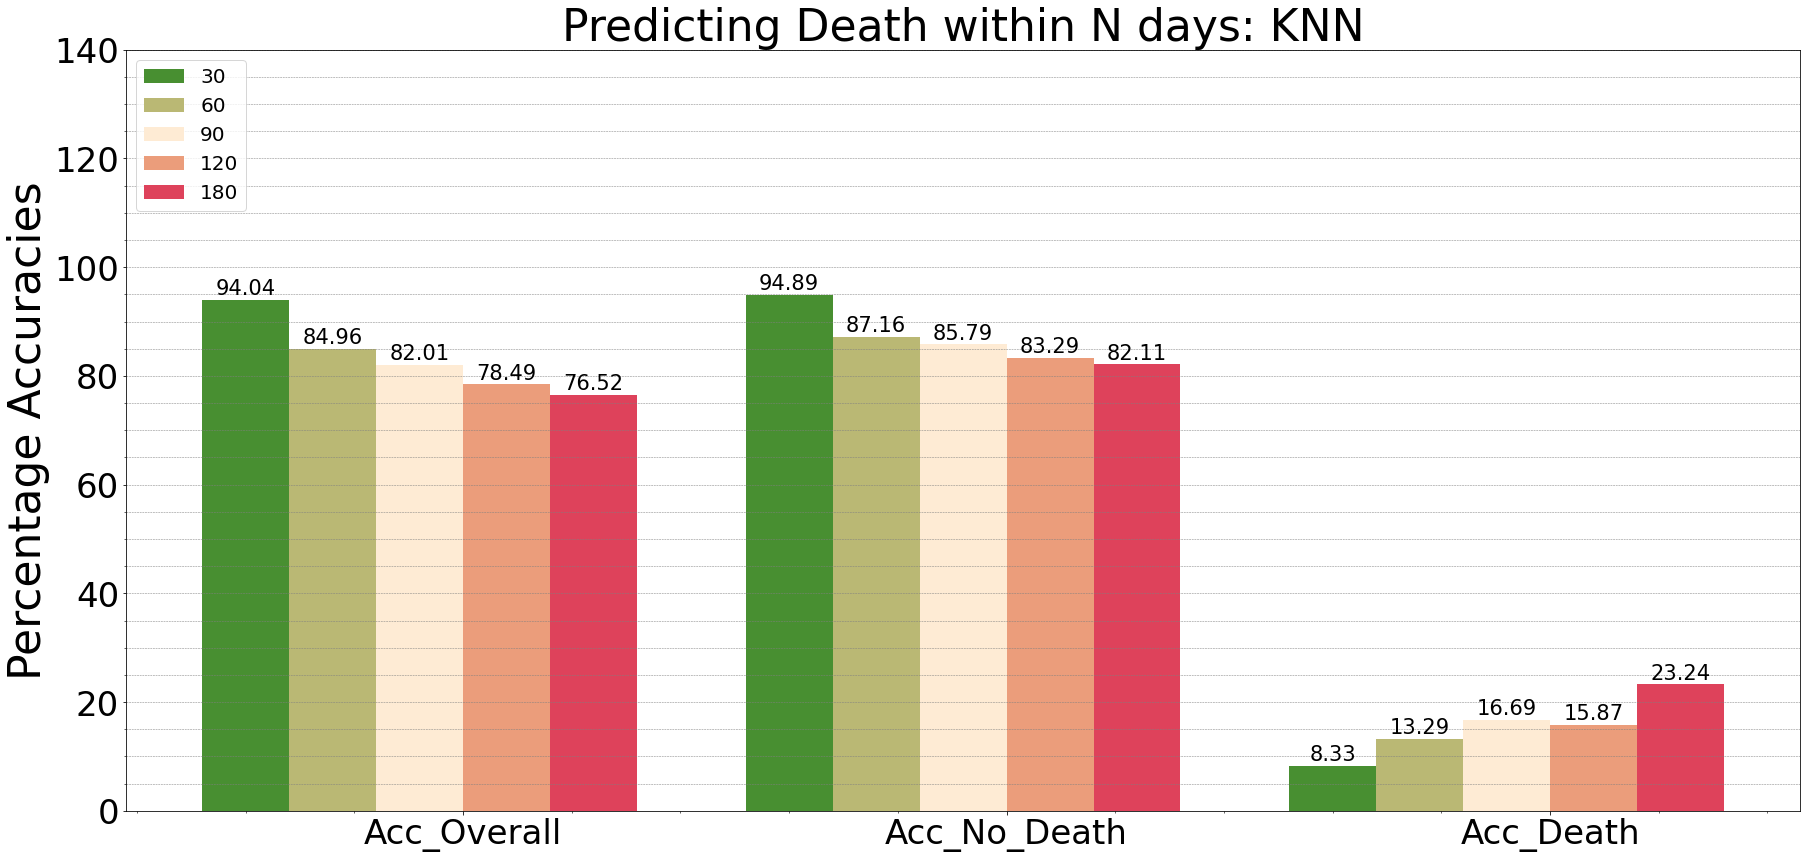

In [9]:
time_comparisons('Death')

## Predictive Models for Death - Feature Importances

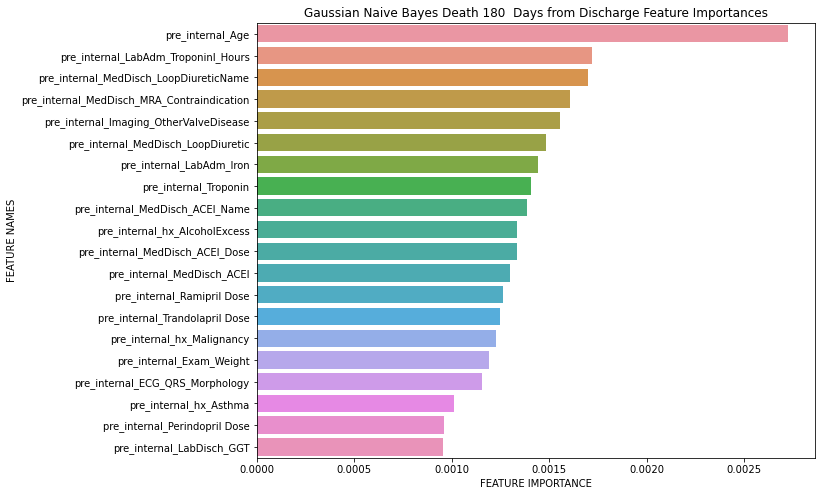

In [10]:
#choose which model you want feature importances for
model_to_see = 'GNB'

#change the time frame within your predictions
t=180

plot_feature_importance(time_graphs1[t][model_to_see][1].head(20),model_names[model_to_see]+' Death '+ str(t)+'  Days from Discharge')

## Predictive Models for Death - Confusion Matrix for a Model

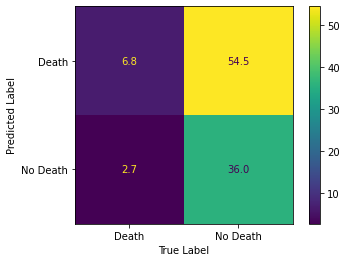

In [11]:
#choose which model you want feature importances for
model_to_see = 'GNB'

#change the time frame within your predictions
t=180

prediction_meanings(time_graphs1[t][model_to_see][0][:-1],"Death")

# Visualizations for Hospitalizations - Classifier

## Predictive Models for Hospitalizations - Load Models

In [12]:
#Select the models and days you want to load for visualizations - make sure the relevant files are there.
models = ['Baseline','GNB','KNN','RF']
days = all_days

#loads them up into this dictionary
time_graphsh={}
for d in days:
    time_graphsh[d]={}

for d in days:
    for model in models:
        with open('../results/'+model+'_'+str(d)+'_hospitalization_classifier_final.pkl', 'rb') as file:
            time_graphsh[d][model] = pickle.load(file)



## Predictive Models for Hospitalizations - Plot comparisons between models and comparisons over time

Dropdown(description='Time to discharge: ', options=(30, 60, 90, 120, 180), value=30)

(<Figure size 2160x1008 with 1 Axes>,
 <AxesSubplot:title={'center':'Predicting Hospitalizations: 30 days from discharge'}, ylabel='Percentage Accuracies'>)

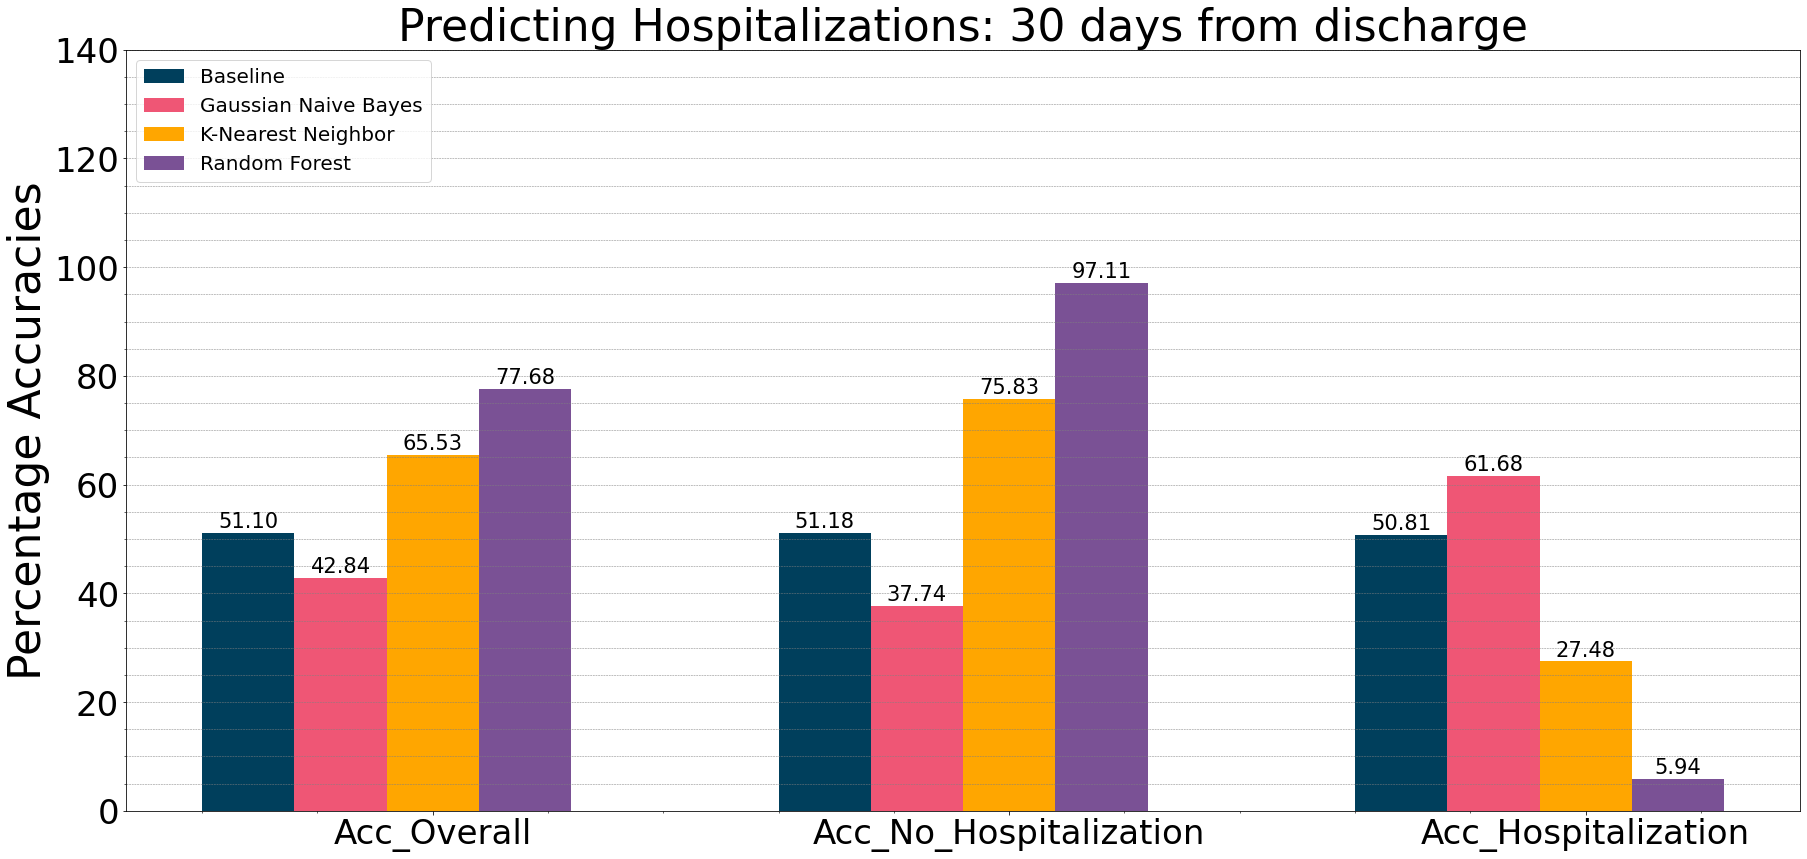

In [13]:
comparisons('Hospitalizations')

In [ ]:
time_comparisons('Hospitalizations')

Dropdown(description='Model: ', index=1, options=('KNN', 'GNB', 'RF', 'Baseline'), value='GNB')

(<Figure size 2160x1008 with 1 Axes>,
 <AxesSubplot:title={'center':'Predicting Hospitalizations within N days: GNB'}, ylabel='Percentage Accuracies'>)

## Predictive Models for Hospitalizations - Feature Importances

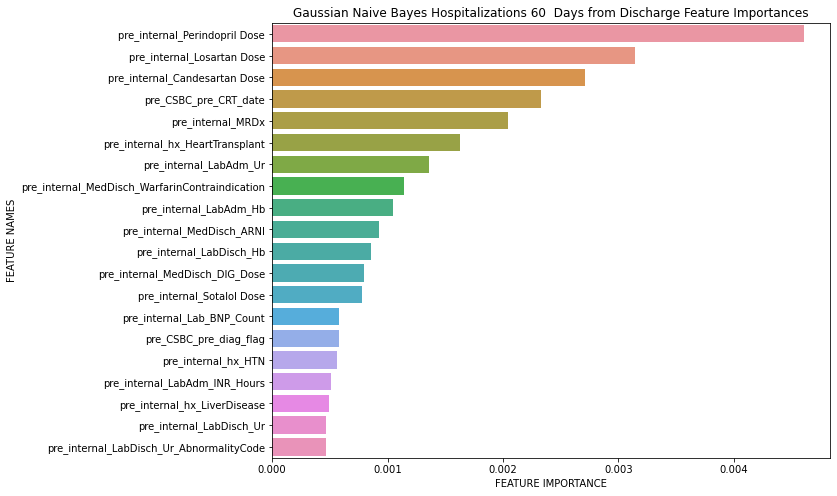

In [15]:
#choose which model you want feature importances for
model_to_see = 'GNB'

#change the time frame within your predictions
t=60

plot_feature_importance(time_graphsh[t][model_to_see][1].head(20),model_names[model_to_see]+' Hospitalizations '+ str(t)+'  Days from Discharge')

## Predictive Models for Hospitalizations - Confusion Matrix for a Model

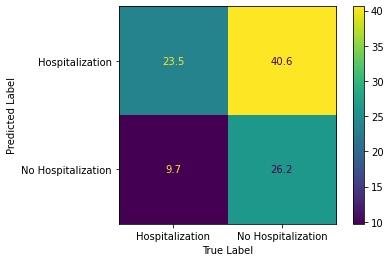

In [16]:
#choose which model you want feature importances for
model_to_see = 'GNB'

#change the time frame within your predictions
t=60

prediction_meanings(time_graphsh[t][model_to_see][0][:-1],"Hospitalizations")

# Visualizations for Hospitalizations - Regression

## Predictive Regression Models for Hospitalization - Load Models

In [17]:
#Select the models and days you want to load
reg_models = ['OLS','Ridge','ETR']

#
reg_model_names={'OLS':'Linear Regression','Ridge':'Ridge Regression','ETR':'Extra Trees Regression'}

#loads them up into this dictionary
time_graphs2={}

for model in reg_models:
    with open('../results/'+model+'_hosp_final.pkl', 'rb') as file:
        time_graphs2[model] = pickle.load(file)[model]
            


In [18]:
#choose which model you want regression scores for
model = 'Ridge'

output_metrics(time_graphs2[model][0])

r2 : -0.1050305319304854
mae: 1.3032751333487267
rmse: 1.556504760633948
auc: 0.60922380748534
Feature Importance                                        importance
pre_internal_VisitAnonId                 0.189115
pre_internal_LabDisch_AST_Hours          0.116411
pre_internal_LabAdm_Ur_Hours             0.082805
pre_internal_LabDisch_Bilirubin_Hours    0.059929
pre_internal_LabDisch_ALT_Hours          0.051292
pre_internal_LabDisch_Ferritin_Hours     0.043569
pre_internal_Age                         0.031577
pre_internal_LabAdm_HbA1C_Hours          0.030781
pre_internal_LabAdm_Platelets            0.021427
pre_internal_BNP                         0.015858


[[(array([1., 1., 3., 2., 1., 3., 4., 3., 1., 3., 3., 5., 1., 1., 1., 3., 2.,
          1., 1., 2., 5., 3., 5., 3., 5., 2., 5., 5., 1., 4., 2., 2., 1., 5.,
          5., 1., 1., 2., 1., 4., 5., 2., 4., 2., 2., 5., 2., 3., 2., 5., 2.,
          2., 2., 1., 1., 5., 5., 4., 3., 1., 1., 1., 3., 1., 1., 2., 2., 2.,
          3., 2., 5., 4., 1., 2., 4., 2., 4., 2., 5., 1., 2., 3., 1., 2., 3.,
          5., 1., 1., 5., 3., 1., 1., 3., 5., 4., 3., 1., 4., 1., 1., 1., 4.,
          2., 1., 1., 3., 4., 5., 5., 1., 1., 4., 1., 1., 1., 2., 3., 5., 3.,
          5., 5., 5., 1., 2., 3., 3., 3., 2., 2., 3., 4., 1., 1., 5., 1., 2.,
          2., 2., 5., 4., 5., 1., 5., 1., 1., 2., 1., 2., 2., 2., 5., 1., 4.,
          5., 1., 1., 3., 1.]),
   array([ 2.87128021,  3.36916162,  3.15962582,  2.68056596,  2.47915009,
           1.75095187,  2.98550452,  3.70158816,  2.62485177,  2.90834923,
           3.15815491,  2.81353197,  3.30911104,  1.95827217,  4.04934169,
           3.19888187,  1.95031037,  1.99

## Predictive Regression Models for Hospitalization - Feature Importances

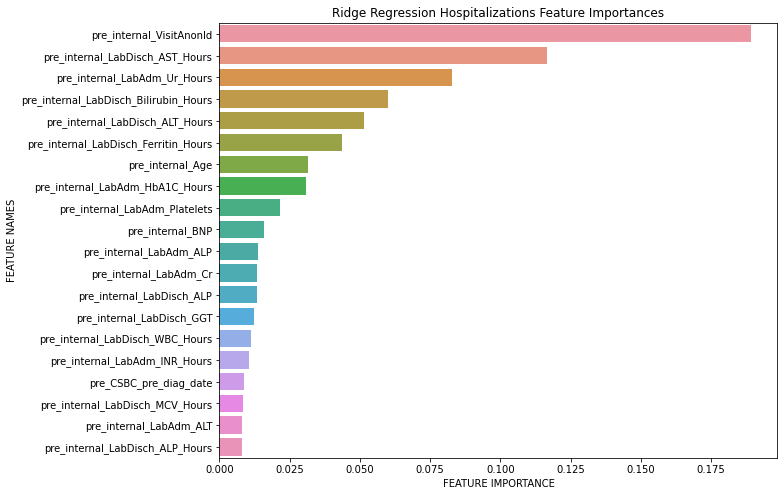

In [19]:
#choose which model you want feature importances for
model_to_see = 'Ridge'

plot_feature_importance(time_graphs2[model_to_see][0][-1].head(20),reg_model_names[model_to_see]+' Hospitalizations')

# Visualizations for Risk

## Predictive Models for Risk - Load Models

In [20]:
#Select the models and days you want to load
models = ['Baseline','GNB','KNN','RF']
days = all_days

#loads them up into this dictionary
time_graphs3={}
for d in days:
    time_graphs3[d]={}

for d in days:
    for model in models:
        with open('../results/'+model+'_'+str(d)+'_risk_final.pkl', 'rb') as file:
            time_graphs3[d][model] = pickle.load(file)



## Predictive Models for Risk - Plot comparisons between models and comparisons over time

Dropdown(description='Time to discharge: ', options=(30, 60, 90, 120, 180), value=30)

(<Figure size 2160x1008 with 1 Axes>,
 <AxesSubplot:title={'center':'Predicting Risk: 30 days from discharge'}, ylabel='Percentage Accuracies'>)

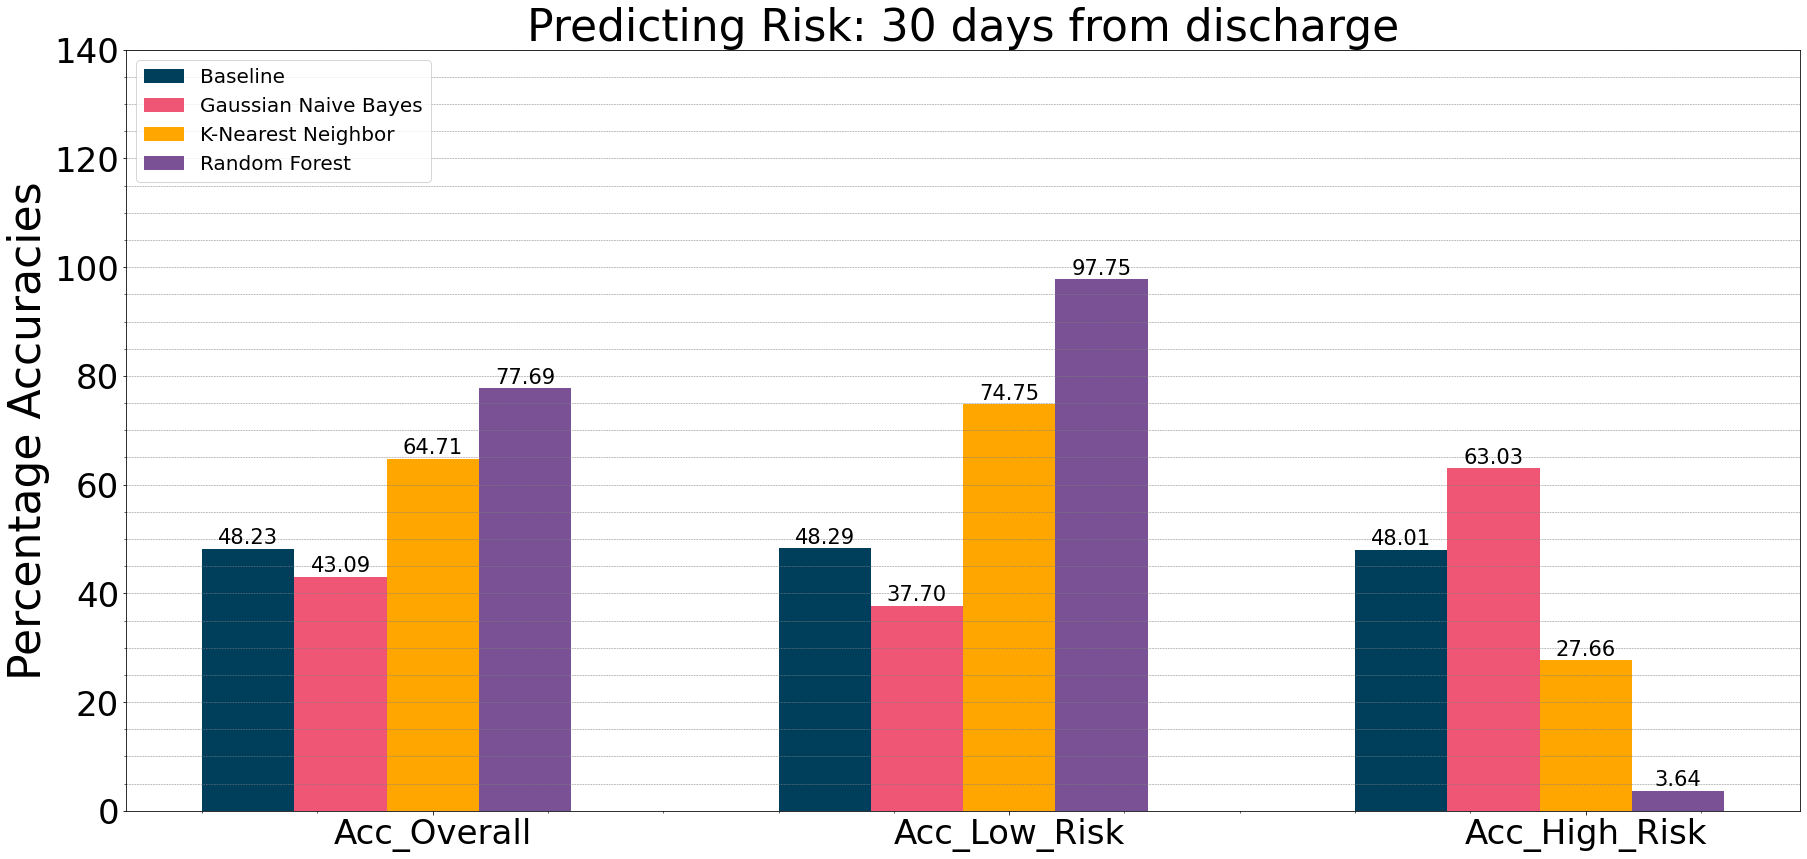

In [21]:
comparisons('Risk')

Dropdown(description='Model: ', options=('KNN', 'GNB', 'RF', 'Baseline'), value='KNN')

(<Figure size 2160x1008 with 1 Axes>,
 <AxesSubplot:title={'center':'Predicting Risk within N days: KNN'}, ylabel='Percentage Accuracies'>)

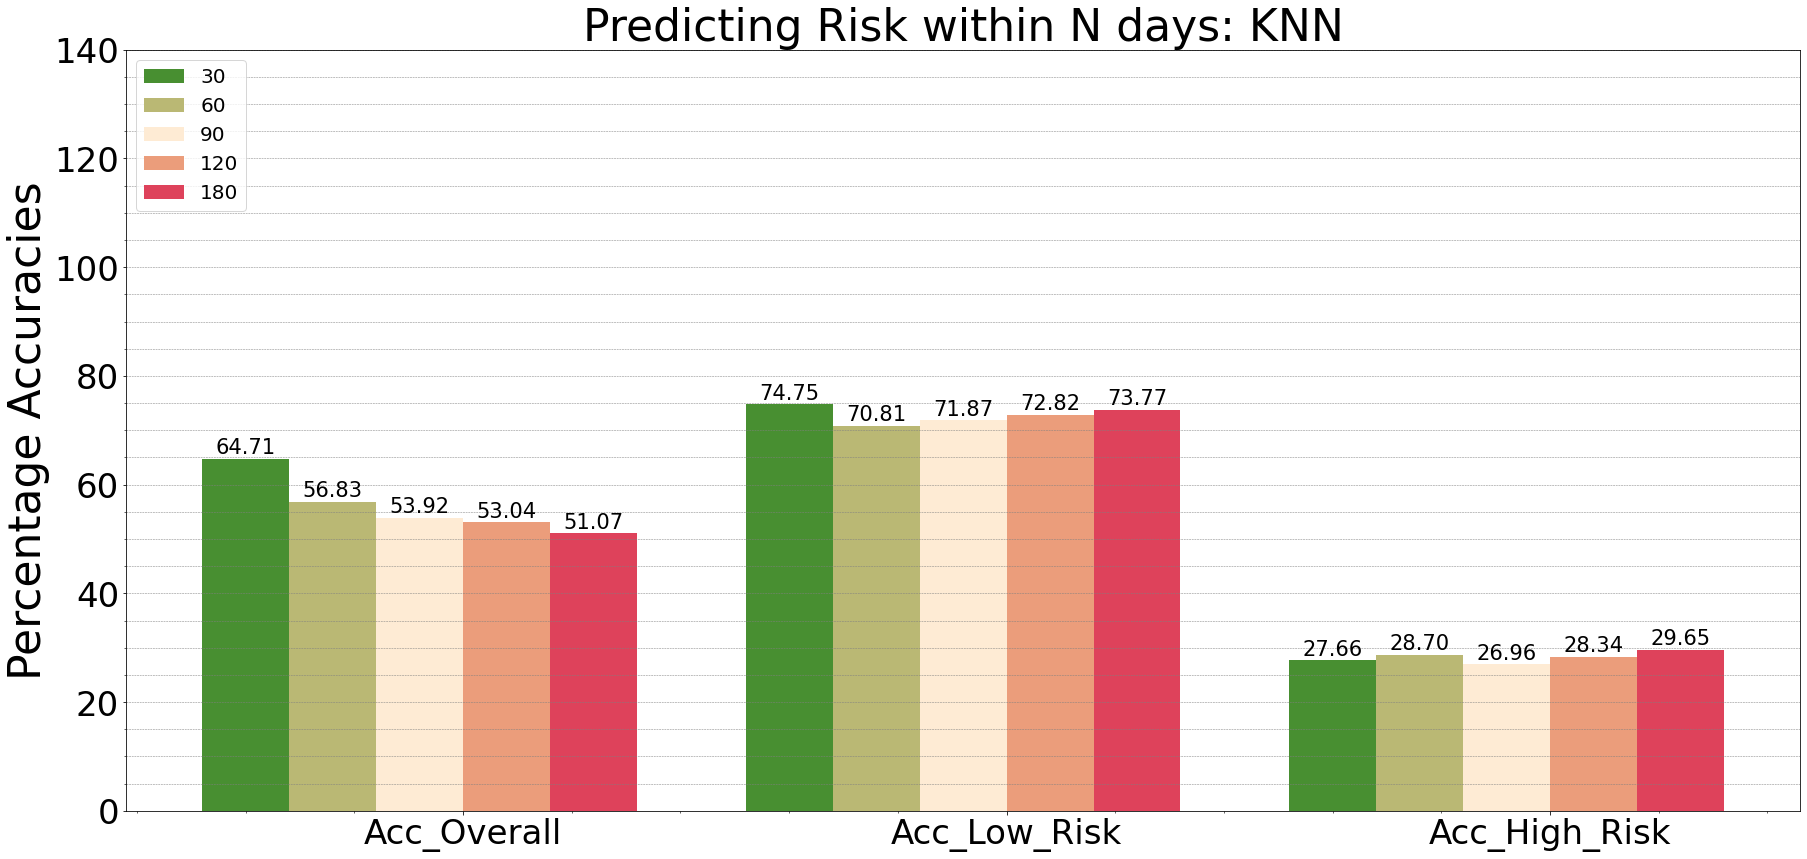

In [22]:
time_comparisons('Risk')

## Predictive Models for Risk - Feature Importances

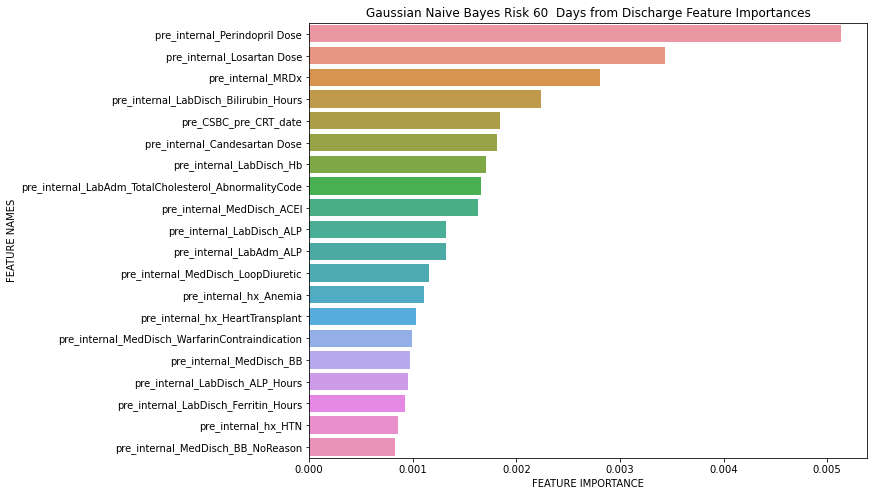

In [23]:
#choose which model you want feature importances for
model_to_see = 'GNB'

#change the time frame within your predictions
t=60

plot_feature_importance(time_graphs3[t][model_to_see][1].head(20),model_names[model_to_see]+' Risk '+ str(t)+'  Days from Discharge')

## Predictive Models for Risk - Confusion Matrix for a Model

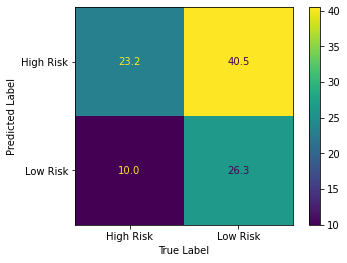

In [24]:
#choose which model you want feature importances for
model_to_see = 'GNB'

#change the time frame within your predictions
t=60

prediction_meanings(time_graphs3[t][model_to_see][0][:-1],"Risk")